# A Recomandation System

*import libraries*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

*Read the Data*

In [2]:
dataframe_1 = pd.read_csv("../Data/tmdb_5000_credits.csv")
dataframe_2 = pd.read_csv("../Data/tmdb_5000_movies.csv")

In [3]:
# join the two dataframes on the movie id
dataframe_1.columns = ['id','tittle','cast','crew']
dataframe_2 = dataframe_2.merge(dataframe_1, on='id')

# Quick check to see if the merge worked
dataframe_2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


---

## **Demographic Filtering**

The concept for this is that the higher the number of positive reviews that are given the better the movie is and hence, it is recommended

### Weighted Average Rating

We can use the Weightied Rating (WR) as a metric to rank our movies. The WR is a combination of the following:

\begin{equation} \text Weighted Rating (\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right) \end{equation}

where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

In [4]:
C = dataframe_2['vote_average'].mean()
print(C)

6.092171559442011


In [5]:
m = dataframe_2['vote_count'].quantile(0.9)
print(m)

1838.4000000000015


In [6]:
q_movies = dataframe_2.copy().loc[dataframe_2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [7]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [8]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [9]:
'''
let's sort the DataFrame in descending order based on the score feature column 
and output the title, vote count, vote average, 
and weighted rating (score) of the top 20 movies.
'''

#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

# Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


In [10]:
pink = (1, 0.078, 0.574, 1)

Text(0.5, 1.0, 'Popular Movies')

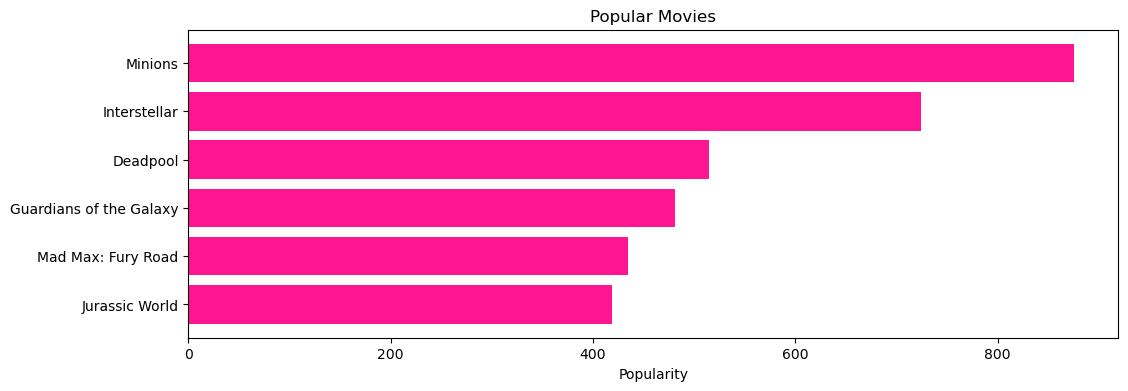

In [11]:
pop = dataframe_2.sort_values('popularity', ascending=False)

plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color=pink)

plt.gca().invert_yaxis()

plt.xlabel("Popularity")
plt.title("Popular Movies")

---

## **Content Based Filtering**

### **Single Value Decomposition**

In [12]:
movies = dataframe_2.copy(deep=True)
dataframe_2['title'].head(5)


0                                      Avatar
1    Pirates of the Caribbean: At World's End
2                                     Spectre
3                       The Dark Knight Rises
4                                 John Carter
Name: title, dtype: object

In [13]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
dataframe_2['overview'] = dataframe_2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(dataframe_2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

### **Cosine Similarity**

Mathematically, it is defined as follows:

\begin{equation} \text cos(x,y) = \left({{\bf x \cdot y^{T}} \over {||x||} \cdot {||y||}}\right) = \left({{\sum_{i=1}^{n} x_{i} \cdot y^{T}_{i}} \over {\sqrt {\sum_{i=1}^{n} x_{i}^{2}{\sum_{i=1}^{n} y_{i}^{2}}}}} \right) \end{equation}

In [14]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse map of indices and movie titles
indices = pd.Series(dataframe_2.index, index=dataframe_2['title']).drop_duplicates()

In [15]:
'''
Function that takes in movie title as input and outputs most similar movies

Get the index of the movie given its title.

Get the list of cosine similarity scores for that particular movie with all movies. 
Convert it into a list of tuples where the first element is its position 
and the second is the similarity score.

Sort the aforementioned list of tuples 
based on the similarity scores; i.e., the second element.

Get the top 10 elements of this list. 
Ignore the first element as it refers to self 
(the movie most similar to a particular movie is the movie itself).

Return the titles corresponding to the indices of the top elements.
'''
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return dataframe_2['title'].iloc[movie_indices]

In [16]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [17]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

### Result
While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

### **Credits, Genres and Keywords Based Recommender**

In [18]:
features = ['cast', 'crew', 'keywords', 'genres']

for feature in features:
    dataframe_2[feature] = dataframe_2[feature].apply(literal_eval)

In [19]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [20]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        # Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [21]:
# Define new director, cast, genres and keywords features that are in a suitable form.
dataframe_2['director'] = dataframe_2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    dataframe_2[feature] = dataframe_2[feature].apply(get_list)

In [22]:
# Print the new features of the first 3 films
dataframe_2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [23]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [24]:
def create_soup(x):
    return ' '.join(str(x['keywords'])) + ' ' + ' '.join(str(x['cast'])) + ' ' + str(x['director']) + ' ' + ' '.join(str(x['genres']))

dataframe_2['soup'] = dataframe_2.apply(create_soup, axis=1)

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the **CountVectorizer()** instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [25]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(dataframe_2['soup'])

In [26]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [27]:
# Reset index of our main DataFrame and construct reverse mapping as before
dataframe_2 = dataframe_2.reset_index()
indices = pd.Series(dataframe_2.index, index=dataframe_2['title'])

We can now reuse our **get_recommendations()** function by passing in the new **cosine_sim2** matrix as your second argument.

In [28]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65                         The Dark Knight
95                            Interstellar
96                               Inception
119                          Batman Begins
1033                              Insomnia
1196                          The Prestige
3573                               Memento
134     Mission: Impossible - Rogue Nation
717                           Jack Reacher
1650                        Wing Commander
Name: title, dtype: object

In [29]:
get_recommendations('The Godfather', cosine_sim2)

1018           The Cotton Club
1167                   Dracula
1209             The Rainmaker
1525            Apocalypse Now
2333     Peggy Sue Got Married
2600          New York Stories
2731    The Godfather: Part II
3012             The Outsiders
3337             The Godfather
3401                     Twixt
Name: title, dtype: object

### **Exporting Variables**

For the WebApplication we would need to export the variables so why not start a fresh variable.

In [30]:
movies = pd.read_csv('../Data/tmdb_5000_movies.csv')
credits = pd.read_csv('../Data/tmdb_5000_credits.csv') 
print(movies.shape)
print(credits.shape)

(4803, 20)
(4803, 4)


In [31]:
movies = movies.merge(credits,on='title')
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [32]:
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]
movies.columns

Index(['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew'], dtype='object')

In [33]:
def convert(text):
    L = []
    for i in literal_eval(text):
        L.append(i['name']) 
    return L 

In [34]:
movies.dropna(inplace=True)
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(convert)
movies['cast'] = movies['cast'].apply(lambda x:x[0:3])

In [35]:
def convert_with_counter(text):
    L = []
    counter = 0
    for i in literal_eval(text):
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L 

def fetch_director(text):
    L = []
    for i in literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])
    return L 

In [36]:
movies['crew'] = movies['crew'].apply(fetch_director)

In [37]:
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

In [38]:
movies['cast'] = movies['cast'].apply(collapse)
movies['crew'] = movies['crew'].apply(collapse)
movies['genres'] = movies['genres'].apply(collapse)
movies['keywords'] = movies['keywords'].apply(collapse)

movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes]
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan]
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton]


In [39]:
movies['overview'] = movies['overview'].apply(lambda x:x.split())
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

In [40]:
movieList = movies.drop(columns=['overview','genres','keywords','cast','crew'])
movieList['tags'] = movieList['tags'].apply(lambda x: " ".join(x))
movieList.head()

,movie_id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...
4,49529,John Carter,"John Carter is a war-weary, former military ca..."


In [41]:
vectorizer = CountVectorizer(max_features=5000,stop_words='english')

vector = vectorizer.fit_transform(movieList['tags']).toarray()
vector.shape

(4806, 5000)

In [42]:
similarity = cosine_similarity(vector)
similarity

array([[1.        , 0.08964215, 0.06071767, ..., 0.02519763, 0.0277885 ,
        0.        ],
       [0.08964215, 1.        , 0.06350006, ..., 0.02635231, 0.        ,
        0.        ],
       [0.06071767, 0.06350006, 1.        , ..., 0.02677398, 0.        ,
        0.        ],
       ...,
       [0.02519763, 0.02635231, 0.02677398, ..., 1.        , 0.07352146,
        0.04774099],
       [0.0277885 , 0.        , 0.        , ..., 0.07352146, 1.        ,
        0.05264981],
       [0.        , 0.        , 0.        , ..., 0.04774099, 0.05264981,
        1.        ]])

In [43]:
def recommend(movie):
    index = movieList[movieList['title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print(movieList.iloc[i[0]].title)

In [44]:
import pickle, gzip

with gzip.open('../pickles/movie_list.pklz', 'wb') as ofp:
    pickle.dump(movieList, ofp)

with gzip.open('../pickles/similarity.pklz', 'wb') as ofp2:
    pickle.dump(similarity, ofp2)

---

## **Collaborative Filtering**

### **Single Value Decomposition**

In [45]:
df = pd.read_csv("../Data/ml-latest/ratings.csv")

In [46]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

In [47]:
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [48]:
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [49]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

In [50]:
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

In [51]:
# cast the ratings to float32
df["rating"] = df["rating"].values.astype(np.float32)

In [52]:
print(
    "Number of users: {}\nNumber of Movies: {}\nMin rating: {}\nMax rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610
Number of Movies: 9724
Min rating: 0.5
Max rating: 5.0


### Prepare training and validation data

In [53]:
df = df.sample(frac=1, random_state=42)

x = df[["user", "movie"]].values
## print(type(x))

# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

## print(type(y))

# Assuming training on 90% of the data and validating on 10%.
# might change this to 99/1
train_indices = int(0.99 * df.shape[0])

In [54]:
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [55]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


In [56]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [57]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
3120/3120 [==============================] - 12s 4ms/step - loss: 0.6297 - val_loss: 0.6177
Epoch 2/10
3120/3120 [==============================] - 11s 4ms/step - loss: 0.6096 - val_loss: 0.6149
Epoch 3/10
3120/3120 [==============================] - 13s 4ms/step - loss: 0.6062 - val_loss: 0.6167
Epoch 4/10
3120/3120 [==============================] - 13s 4ms/step - loss: 0.6040 - val_loss: 0.6130
Epoch 5/10
3120/3120 [==============================] - 13s 4ms/step - loss: 0.6028 - val_loss: 0.6133
Epoch 6/10
3120/3120 [==============================] - 13s 4ms/step - loss: 0.6019 - val_loss: 0.6141
Epoch 7/10
3120/3120 [==============================] - 13s 4ms/step - loss: 0.6010 - val_loss: 0.6131
Epoch 8/10
3120/3120 [==============================] - 11s 4ms/step - loss: 0.6011 - val_loss: 0.6128
Epoch 9/10
3120/3120 [==============================] - 11s 3ms/step - loss: 0.6006 - val_loss: 0.6131
Epoch 10/10
3120/3120 [==============================] - 11s 4ms/step - l

In [58]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [59]:
"""
sklearn OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
thank you stackoverflow
https://stackoverflow.com/questions/20554074/sklearn-omp-error-15-initializing-libiomp5md-dll-but-found-mk2iomp5md-dll-a
"""
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

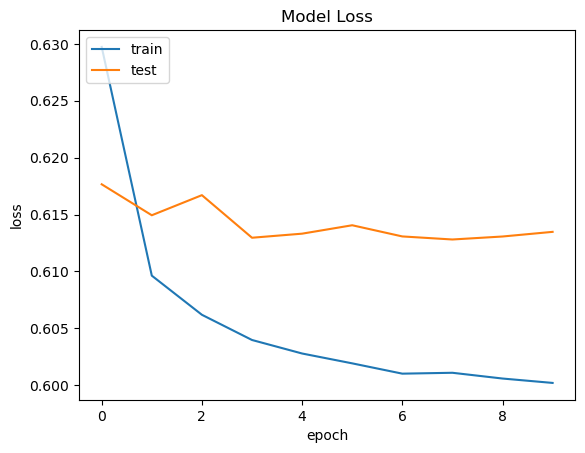

In [60]:
plt.plot(loss)
plt.plot(val_loss)
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.savefig("../images/loss.png")
plt.show()

In [61]:
movie_df = pd.read_csv("../Data/ml-latest/movies.csv")

# Let us get a user and see the top recommendations.

# Pick a user at random.
user_id = df.userId.sample(1).iloc[0]  

# Get all movies watched by the user.
movies_watched_by_user = df[df.userId == user_id] 

# Get the movies not watched by the user.
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]

movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]

recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)

top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("\n")
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 6
Movies with high ratings from user
--------------------------------
Dolores Claiborne (1995) : Drama|Thriller
Secret of Roan Inish, The (1994) : Children|Drama|Fantasy|Mystery
Tommy Boy (1995) : Comedy
Ghost (1990) : Comedy|Drama|Fantasy|Romance|Thriller
Aladdin (1992) : Adventure|Animation|Children|Comedy|Musical


--------------------------------
Top 10 movie recommendations
--------------------------------
Secrets & Lies (1996) : Drama
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Ran (1985) : Drama|War
Godfather: Part II, The (1974) : Crime|Drama
Touch of Evil (1958) : Crime|Film-Noir|Thriller
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller


---